<a href="https://colab.research.google.com/github/abdelrahmanMo/Finding_Donors_Charity-KNN-NB/blob/master/Finding_Donors_Charity_KNN_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
#from scikitplot.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


In [85]:
data = pd.read_csv('/content/drive/My Drive/MarkovApplied/section4/census.csv')

In [86]:
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


# Data exploration

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [88]:
# Total number of records 
n_records = len(data) 

# Number of records where individual's income is more than $50,000
n_greater_50k= len(data[data['income']==">50K"])

#آNumber of records where individual's income is at most $50,000
n_less_50k = len(data[data['income']=="<=50K"])

# Percentage of individual's whose income is more than $50,000
greater_percent = round((n_greater_50k/n_records)*100)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_less_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 25%


In [89]:
data['income'].value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

# Preparing the Data

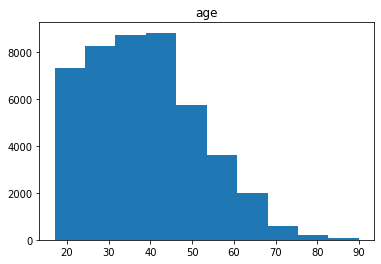

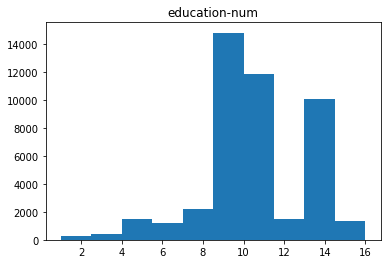

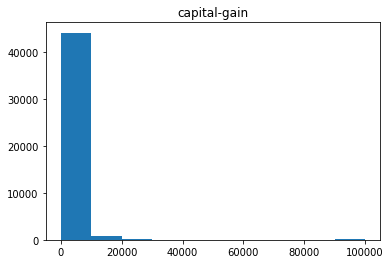

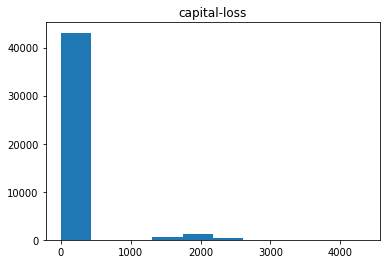

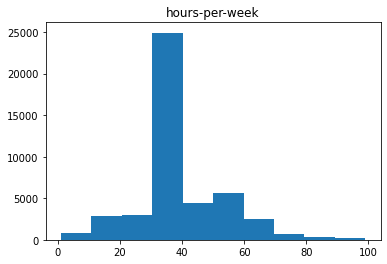

In [90]:
new_features = data.columns[data.dtypes!='object']
def my_plot(feature):
  plt.hist(data[feature])
  plt.title(feature)
  plt.show()

for feature in new_features:
  my_plot(feature)


In [91]:
data['capital-gain_log'] = np.log((data['capital-gain'])+1)
data['capital-loss_log'] = np.log((data['capital-loss'])+1)

In [92]:
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,capital-gain_log,capital-loss_log
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,7.684784,0.0
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,0.000000,0.0
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,0.000000,0.0
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,0.000000,0.0
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,0.000000,0.0


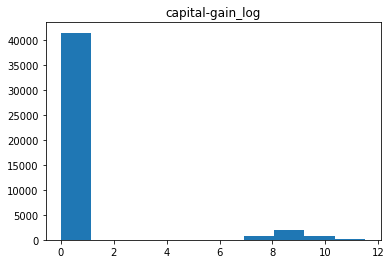

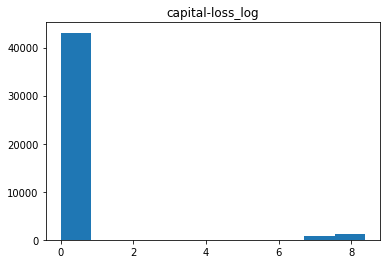

In [93]:
for i in ['capital-gain_log', 'capital-loss_log']:
    my_plot(i)

In [94]:
data_log_transformed = data.drop(['capital-gain', 'capital-loss'], axis=1)
data_log_transformed.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-gain_log,capital-loss_log
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,40.0,United-States,<=50K,7.684784,0.0
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,13.0,United-States,<=50K,0.000000,0.0
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,40.0,United-States,<=50K,0.000000,0.0
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40.0,United-States,<=50K,0.000000,0.0
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40.0,Cuba,<=50K,0.000000,0.0


# Data preprocessing

In [95]:
# Encode the 'income_label' data to numerical values
data_log_transformed['income'].replace({"<=50K":0, ">50K":1}, inplace=True)
data_log_transformed.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-gain_log,capital-loss_log
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,40.0,United-States,0,7.684784,0.0
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,13.0,United-States,0,0.000000,0.0
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,40.0,United-States,0,0.000000,0.0
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40.0,United-States,0,0.000000,0.0
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40.0,Cuba,0,0.000000,0.0


In [96]:
# One-hot encode the categorical features data
data_cat_transformed = pd.get_dummies(data_log_transformed, drop_first=True)

# Print the number of features after one-hot encoding
print("{} total features after one-hot encoding.".format(len(data_cat_transformed.columns)))
print(data_cat_transformed.columns)

96 total features after one-hot encoding.
Index(['age', 'education-num', 'hours-per-week', 'income', 'capital-gain_log',
       'capital-loss_log', 'workclass_ Local-gov', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'education_level_ 11th', 'education_level_ 12th',
       'education_level_ 1st-4th', 'education_level_ 5th-6th',
       'education_level_ 7th-8th', 'education_level_ 9th',
       'education_level_ Assoc-acdm', 'education_level_ Assoc-voc',
       'education_level_ Bachelors', 'education_level_ Doctorate',
       'education_level_ HS-grad', 'education_level_ Masters',
       'education_level_ Preschool', 'education_level_ Prof-school',
       'education_level_ Some-college', 'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',

# shuffle and split data 

In [97]:
# Split the data into features and target label
X = data_cat_transformed.drop('income', axis=1)
y = data_cat_transformed['income']

In [98]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


# Normalizing Numerical feature

In [99]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [100]:
# Show an example with scaling applied
X_train_scaled

array([[0.4109589 , 0.6       , 0.5       , ..., 1.        , 0.        ,
        0.        ],
       [0.43835616, 0.53333333, 0.39795918, ..., 1.        , 0.        ,
        0.        ],
       [0.05479452, 0.66666667, 0.35714286, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.56164384, 0.8       , 0.55102041, ..., 1.        , 0.        ,
        0.        ],
       [0.53424658, 0.53333333, 0.39795918, ..., 1.        , 0.        ,
        0.        ],
       [0.23287671, 0.53333333, 0.34693878, ..., 1.        , 0.        ,
        0.        ]])

In [101]:
y_train_scaled = y_train.reset_index(drop=True)
y_train_scaled

0        0
1        0
2        0
3        1
4        0
        ..
36172    0
36173    1
36174    1
36175    0
36176    0
Name: income, Length: 36177, dtype: int64

In [102]:
y_test_scaled = y_test.reset_index(drop=True)
y_test_scaled

0       0
1       0
2       0
3       0
4       0
       ..
9040    0
9041    0
9042    0
9043    0
9044    1
Name: income, Length: 9045, dtype: int64

# Supervised Learning Models

In [103]:
def train_predict(classifier): 
    '''
    inputs:
       - classifier: the learning algorithm to be trained and predicted on
    '''
    
    results = {}
    
    # Fit the classifier to the training data and Calculate the time
    start_train = time()
    classifier = classifier.fit(X_train_scaled, y_train_scaled)
    end_train = time()
    results['train_time'] = round((end_train-start_train), 2)

    # Predict the training/testing labels and Calculate the time
    start_test = time()
    y_pred_train = classifier.predict(X_train_scaled)
    y_pred_test = classifier.predict(X_test_scaled)
    end_test = time()   
    results['pred_time'] = round((end_test-start_test), 2)
            
    # Model evaluation (training/testing data) using accuracy
    results['acc_train'] = round(accuracy_score(y_train_scaled, y_pred_train), 2)
    results['acc_test'] = round(accuracy_score(y_test_scaled, y_pred_test), 2)
    
    # Model evaluation (training/testing data) using f1-score
    results['f1_train'] = round(f1_score(y_train_scaled, y_pred_train), 2)
    results['f1_test'] = round(f1_score(y_test_scaled, y_pred_test), 2)
    
    # Display classification_report
    report = classification_report(y_test_scaled, y_pred_test)
       
    
    # Return the results
    return results, report

# Initialize the classifiers


In [104]:
# Initialize the classifiers
#clf_DT = DecisionTreeClassifier(random_state=0)
#clf_LR = LogisticRegression(random_state=0)

clf_KNN = KNeighborsClassifier(n_neighbors=2)
clf_NB =  GaussianNB()

clf_list = [clf_KNN,clf_NB]

# Compare evaluation of the different classifiers
clf_evaluation = {}
clf_report = {}

for clf in clf_list:
    clf_evaluation[clf.__class__.__name__] = train_predict(clf)[0]
    clf_report[clf.__class__.__name__] = train_predict(clf)[1]

In [105]:
clf_evaluation

{'GaussianNB': {'acc_test': 0.58,
  'acc_train': 0.58,
  'f1_test': 0.52,
  'f1_train': 0.52,
  'pred_time': 0.05,
  'train_time': 0.08},
 'KNeighborsClassifier': {'acc_test': 0.81,
  'acc_train': 0.89,
  'f1_test': 0.51,
  'f1_train': 0.72,
  'pred_time': 81.34,
  'train_time': 1.82}}

In [106]:
print(clf_report['KNeighborsClassifier'])

              precision    recall  f1-score   support

           0       0.83      0.95      0.88      6840
           1       0.70      0.40      0.51      2205

    accuracy                           0.81      9045
   macro avg       0.77      0.67      0.70      9045
weighted avg       0.80      0.81      0.79      9045



In [107]:
print(clf_report['GaussianNB'])

              precision    recall  f1-score   support

           0       0.96      0.47      0.63      6840
           1       0.36      0.93      0.52      2205

    accuracy                           0.58      9045
   macro avg       0.66      0.70      0.57      9045
weighted avg       0.81      0.58      0.60      9045



In [108]:
legend = []
for i in range(len(clf_list)):
    legend.append(clf_list[i].__class__.__name__)

In [109]:
def eval_plot(labels, y_label, title):

    clf1 = [clf_evaluation[legend[0]][labels[0]], clf_evaluation[legend[0]][labels[1]]]
    clf2 = [clf_evaluation[legend[1]][labels[0]], clf_evaluation[legend[1]][labels[1]]]
  #  clf3 = [clf_evaluation[legend[2]][labels[0]], clf_evaluation[legend[2]][labels[1]]]
   # clf4 = [clf_evaluation[legend[3]][labels[0]], clf_evaluation[legend[3]][labels[1]]]
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x - width/2, clf1, width, label=legend[0])
    ax.bar(x + width/2, clf2, width, label=legend[1])
   # ax.bar(x + width*3/2, clf3, width, label=legend[2])
   # ax.bar(x + width*5/2, clf4, width, label=legend[3])
    # Add labels, title, and legend
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Add bars annotation
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+(width/2), i.get_height()+0.01,
                str(i.get_height()), fontsize=11,
                color='black', ha='center')

    plt.show()


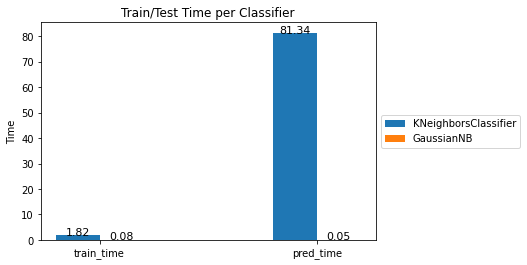

In [110]:
labels = ['train_time', 'pred_time']
y_label = 'Time'
title = 'Train/Test Time per Classifier'
eval_plot(labels, y_label, title)

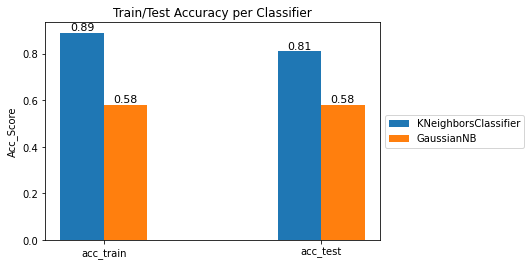

In [111]:
labels = ['acc_train', 'acc_test']
y_label = 'Acc_Score'
title = 'Train/Test Accuracy per Classifier'
eval_plot(labels, y_label, title)

# Improving Results

In [112]:
def model_tuning(clf, parameters):    

    # Evaluate using f1_score scoring object 
    scorer = make_scorer(f1_score)

    # Perform grid search on the classifier and tune parameters, using scorer evaluation
    grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train_scaled, y_train_scaled)

    # Get the best estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and the best model
    y_pred = (clf.fit(X_train_scaled, y_train_scaled)).predict(X_test_scaled)
    y_best_pred = best_clf.predict(X_test_scaled)

    # Report the before-and-after scores
    print("Unoptimized {} model\n------".format(clf.__class__.__name__))
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test_scaled, y_pred)))
    print("F1-score on testing data: {:.4f}".format(f1_score(y_test_scaled, y_pred)))
    print("\nOptimized Model\n------".format(clf.__class__.__name__))
    print("Final Accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_scaled, y_best_pred)))
    print("Final F1-score on the testing data: {:.4f}".format(f1_score(y_test_scaled, y_best_pred)))
    
    
    return clf, best_clf, y_pred, y_best_pred

In [113]:
clf = KNeighborsClassifier(n_neighbors=2)
parameters = {'n_neighbors':[1, 2, 3, 4, 5,6],'leaf_size':[5,20,30,50],'p':[1,2]}

clf, best_clf, y_pred, y_best_pred = model_tuning(clf, parameters)

Unoptimized KNeighborsClassifier model
------
Accuracy score on testing data: 0.8132
F1-score on testing data: 0.5121

Optimized Model
------
Final Accuracy score on the testing data: 0.8205
Final F1-score on the testing data: 0.6163


In [115]:
clf
best_clf

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')

In [116]:
!pip install nbconvert

In [117]:
!jupyter nbconvert --to html /content/Assignment4.ipynb

[NbConvertApp] Converting notebook /content/Assignment4.ipynb to html
[NbConvertApp] Writing 430133 bytes to /content/Assignment4.html
